In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import cmath
import scipy.signal as spsig
# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'k'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 15
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500
# plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['image.cmap'] = 'viridis'

# res = 1000
# MC_N = int(1e4)
# peakVals = 1

res = 500
MC_N = int(4e4)
peakVals = 1

In [2]:
Delta_ZPL_0 = 406.83  # 406 THz  Meesala
lambda_SO_gs = 46e-3  # 46 GHz  Meesala
lambda_SO_es = 255e-3  # 255 GHz  Meesala

# Delta_ZPL_0 = 0.  # 406 THz  Meesala
# lambda_SO_gs = 0.  # 46 GHz  Meesala
# lambda_SO_es = 0.  # 255 GHz  Meesala

t_para = -1.7e3  # -1.7 PHz/strain  Meesala
t_perp = 0.078e3  # 0.078 PHz/strain   Meesala
d_gs = 1.3e3  # 1.3 PHz/strain   Meesala
d_es = 1.8e3  # 1.8 PHz/strain   Meesala
f_gs = -1.7e3  # -1.7 PHz/strain   Meesala
f_es = -3.4e3 # -3.4 PHz/strain   Meesala

StdDev_direc = 4e-4
StdDev_shear = 1e-4

# StdDev_direc = 2.5e-4
# StdDev_shear = 2.5e-4

gamma_10 = 1.33e-3  # 28 GHz p.3 or 1.33 Ghz p.5 Smallwood PRL
# gamma_10 = 1e-4 # fwhm = 10e-3 Kelsey

poi = -0.2  # Poisson ratio of diamond, Kelsey

# nu_t_min = 406.5
# nu_t_max = 407.1

# nu_t_min = 405.5
# nu_t_max = 408.75

# nu_t_min = -0.5
# nu_t_max = 0.5

# nu_t_min = Delta_ZPL_0 - 0.25
# nu_t_max = Delta_ZPL_0 + 0.25

nu_t_min = Delta_ZPL_0-lambda_SO_es+lambda_SO_gs - 3
nu_t_max = Delta_ZPL_0-lambda_SO_es+lambda_SO_gs + 3

nu_t = np.linspace(nu_t_min, nu_t_max, res)
nu_tau = np.linspace(-nu_t_max, -nu_t_min, res)

In [3]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

In [4]:
nu_t_mesh, nu_tau_mesh = np.meshgrid(nu_t, nu_tau, indexing='xy')

In [5]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def abs2(x):

    return x.real**2. + x.imag**2.

In [6]:
@numba.jit
def Delta_ZPL(eps_xx=0., 
              eps_yy=0., 
              eps_zz=0.):
    
    return Delta_ZPL_0 + t_para*eps_zz + t_perp*(eps_xx + eps_yy)

In [7]:
@numba.jit
def Delta_gs(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_gs**2.,
            4. * (d_gs * (eps_xx - eps_yy) + f_gs * eps_yz)**2.,
            4. * (-2. * d_gs * eps_xy + f_gs * eps_zx)**2.
        ]))

In [8]:
@numba.jit
def Delta_es(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_es**2.,
            4. * (d_es * (eps_xx - eps_yy) + f_es * eps_yz)**2.,
            4. * (-2. * d_es * eps_xy + f_es * eps_zx)**2.
        ]))

In [9]:
@numba.jit
def rho(nu_t,
        nu_tau,
        eps_xx=0.,
        eps_yy=0.,
        eps_zz=0.,
        eps_yz=0.,
        eps_xy=0.,
        eps_zx=0.):

    Del_ZPL = Delta_ZPL(eps_xx, eps_yy, eps_zz)

    Del_gs = Delta_gs(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    Del_es = Delta_es(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    if peakVals:
    
        amp = np.array(
            [0.0938, 0.0833, 0.0579, 0.0576,
             0.0709, 1.0000, 0.0799, 0.1521, 
             0.0631, 0.0837, 0.3036, 0.0737, 
             0.0522, 0.1212, 0.0581, 0.1228])

    else:
    
        amp = np.array(
            [1., 1., 1., 1., 
             1., 1., 1., 1., 
             1., 1., 1., 1., 
             1., 1., 1., 1.])
        
#         amp = np.array(
#             [1., 0., 0., 0., 
#              0., 0., 0., 0., 
#              0., 0., 0., 0., 
#              0., 0., 0., 0.])

    sign = np.array([[ 1.,  1.,  1.,  1.], 
                     [ 1.,  1.,  1., -1.], 
                     [ 1.,  1., -1.,  1.],
                     [ 1.,  1., -1., -1.], 
                     [ 1., -1.,  1.,  1.], 
                     [ 1., -1.,  1., -1.],
                     [ 1., -1., -1.,  1.], 
                     [ 1., -1., -1., -1.],
                     [-1.,  1.,  1.,  1.], 
                     [-1.,  1.,  1., -1.], 
                     [-1.,  1., -1.,  1.],
                     [-1.,  1., -1., -1.], 
                     [-1., -1.,  1.,  1.],
                     [-1., -1.,  1., -1.], 
                     [-1., -1., -1.,  1.],
                     [-1., -1., -1., -1.]])

    RHO = 1.j * np.zeros(np.shape(nu_t))

    for i in range(np.shape(sign)[0]):
        t_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            nu_t - (Del_ZPL + sign[i, 0]*Del_gs/2. + sign[i, 1]*Del_es/2. -
                       1.j * gamma_10))
        tau_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            nu_tau + (Del_ZPL + sign[i, 2]*Del_gs/2. + sign[i, 3]*Del_es/2. +
                         1.j * gamma_10))

        RHO += t_Lorentz * tau_Lorentz

    return RHO

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_5063/3842072348.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rho" failed type inference due to: Invalid use of type(CPUDispatcher(<function Delta_gs at 0x7fd77fbcb5e0>)) with parameters (float64, float64, float64, float64, float64)

During: resolving callee type: type(CPUDispatcher(<function Delta_gs at 0x7fd77fbcb5e0>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_5063/3842072348.py (13)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_5063/3842072348.py", line 13:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_5063/3842072348.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "rho" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.Li

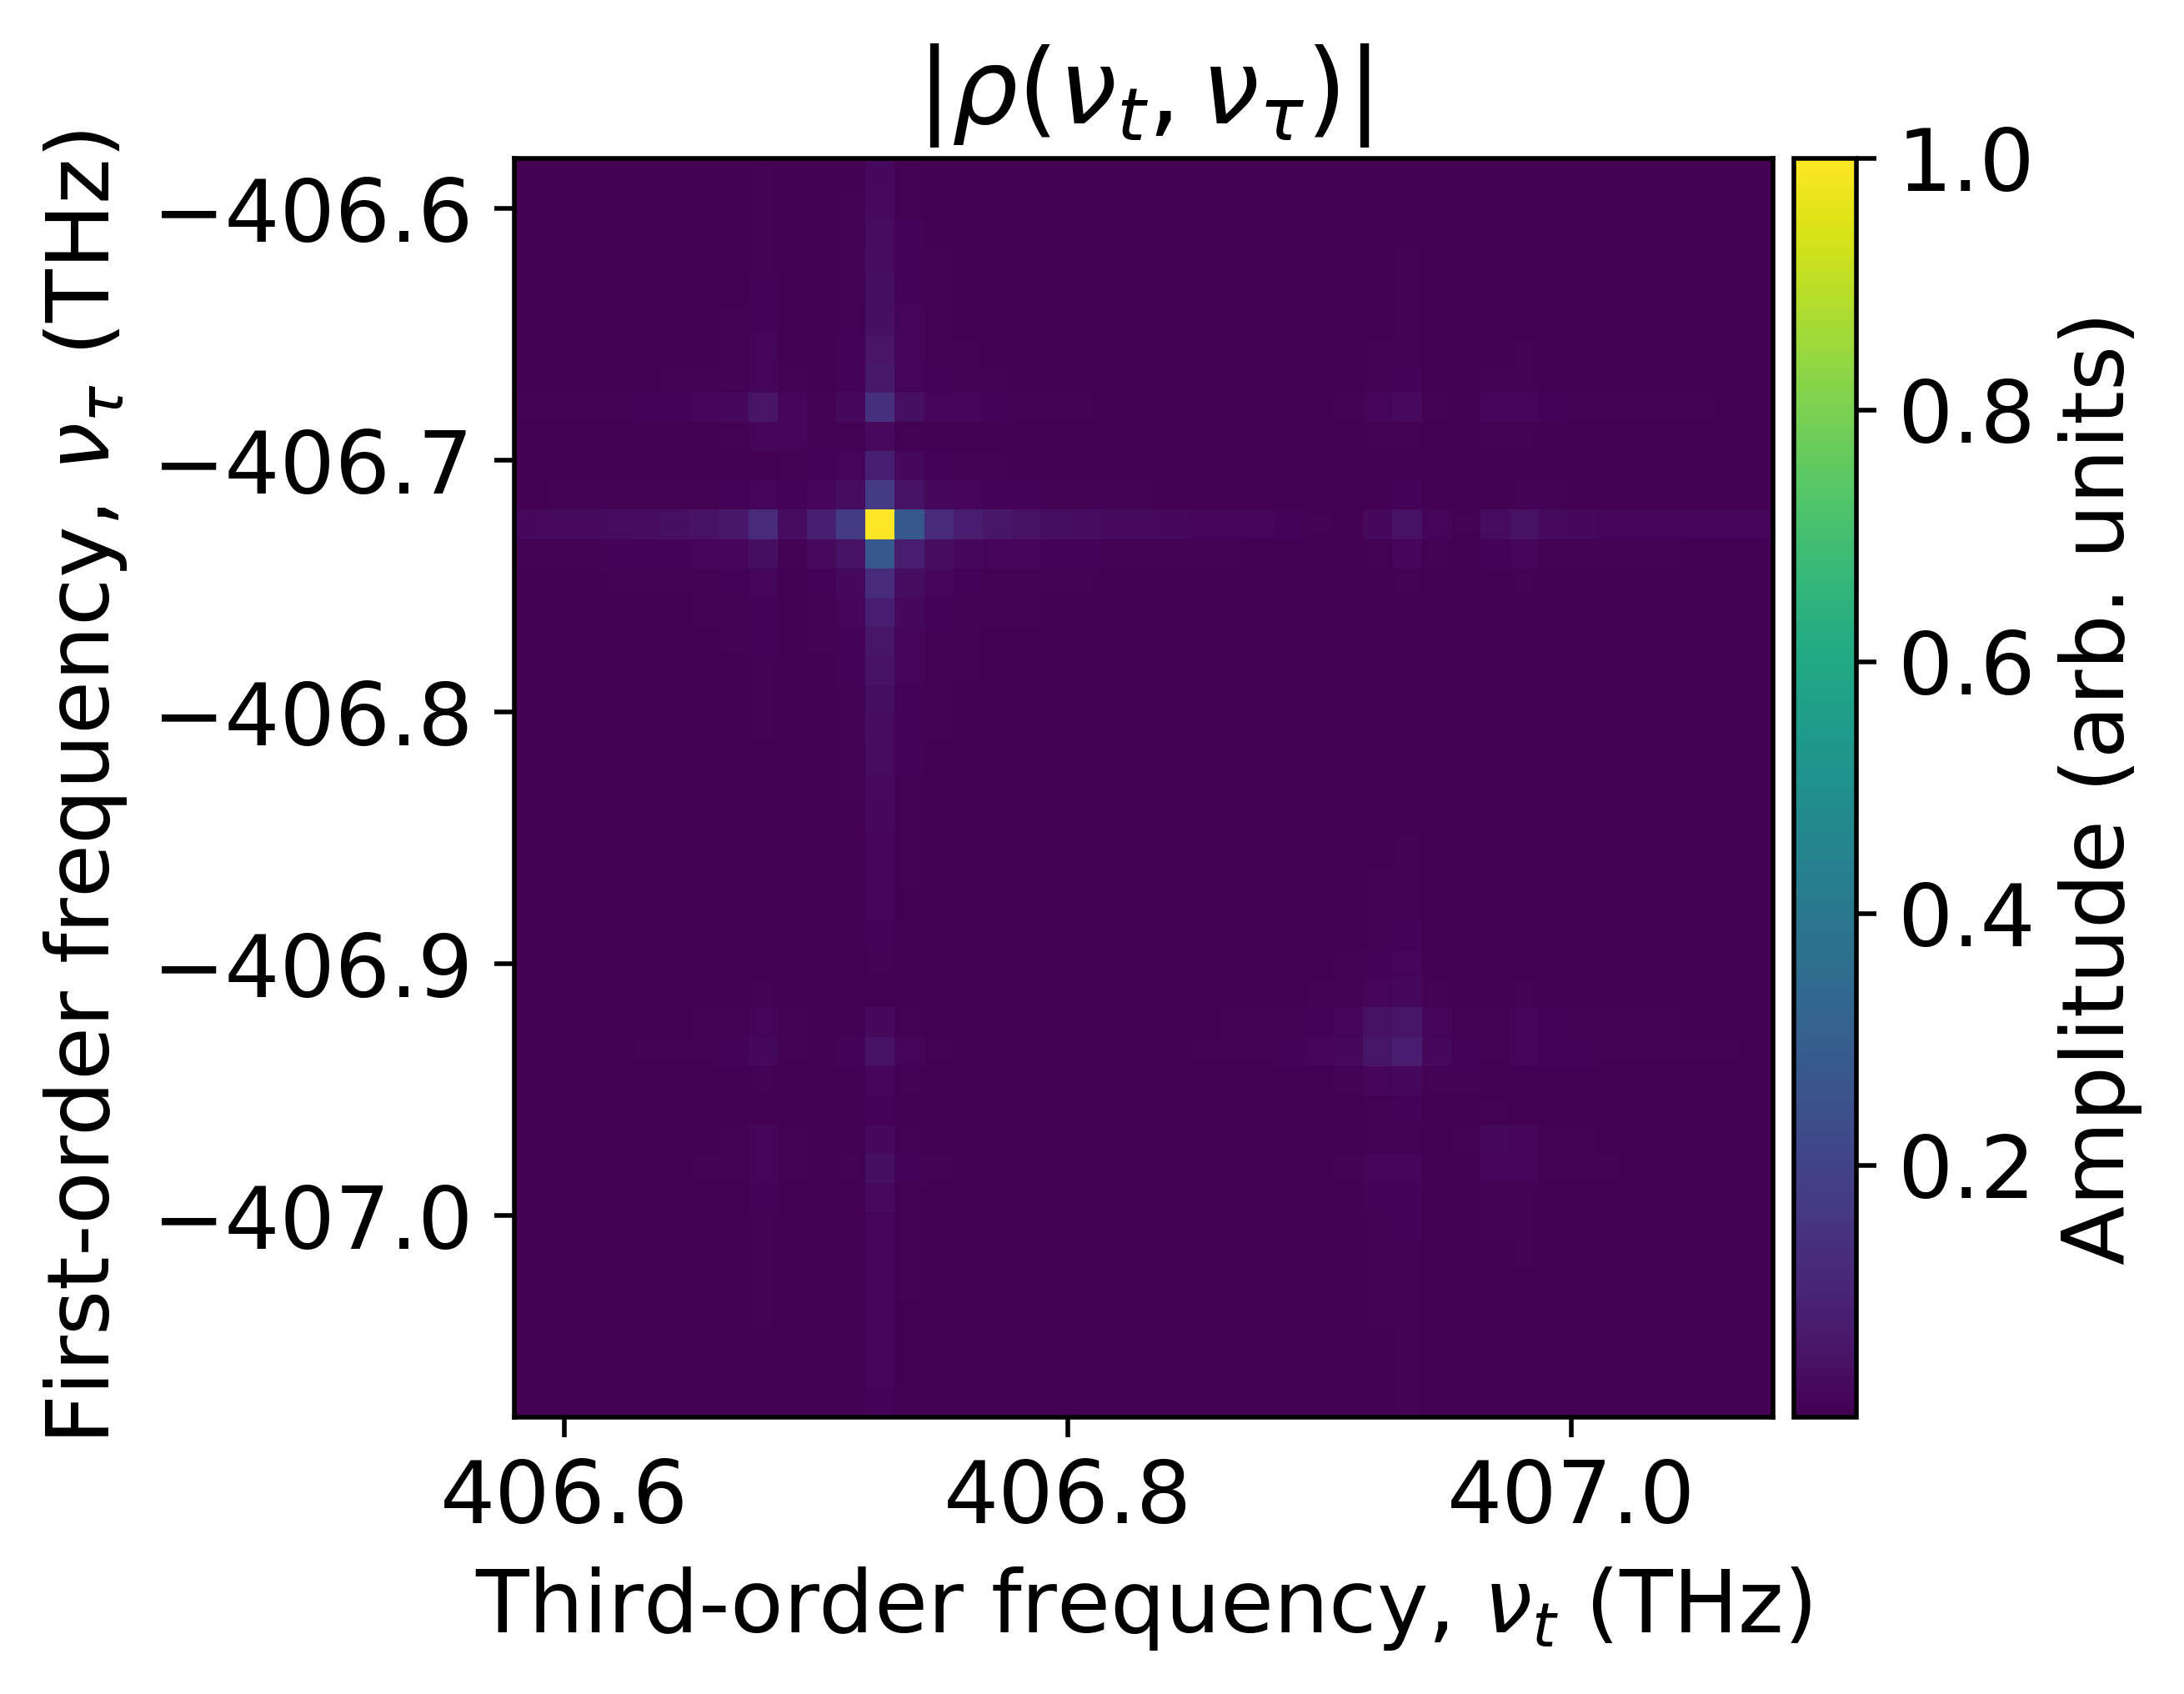

In [10]:
RHO = rho(nu_t_mesh, nu_tau_mesh)

minPlt = Delta_ZPL_0 - 0.25   # THz
maxPlt = Delta_ZPL_0 + 0.25  # THz

# minPlt = nu_t_min   # THz
# maxPlt = nu_t_max  # THz

minInd_t = np.argmin(np.abs(nu_t-minPlt))
maxInd_t = np.argmin(np.abs(nu_t-maxPlt))

minInd_tau = np.argmin(np.abs(nu_tau+maxPlt))
maxInd_tau = np.argmin(np.abs(nu_tau+minPlt))

RHO = RHO[minInd_tau:maxInd_tau+1,minInd_t:maxInd_t+1]

RHO = np.sqrt(abs2(RHO)) / np.sqrt(abs2(np.max(RHO)))

EXTENT=(minPlt, maxPlt, -maxPlt, -minPlt)
fig = plt.figure()
im = plt.imshow(np.sqrt(abs2(RHO)) / np.sqrt(abs2(np.max(RHO))), origin='lower', extent=EXTENT)
colorbar(im, 'Amplitude (arb. units)')
plt.ylabel(r'First-order frequency, $\nu_\tau$ (THz)')
plt.xlabel(r'Third-order frequency, $\nu_t$ (THz)')
plt.title(r'$\left |\rho (\nu_t, \nu_\tau) \right |$')
plt.show()

fig.savefig("/Users/tommychin/Documents/research/Smallwood_research/paper/SingleLorentz.eps", 
                 format='eps', 
                 bbox_inches='tight')

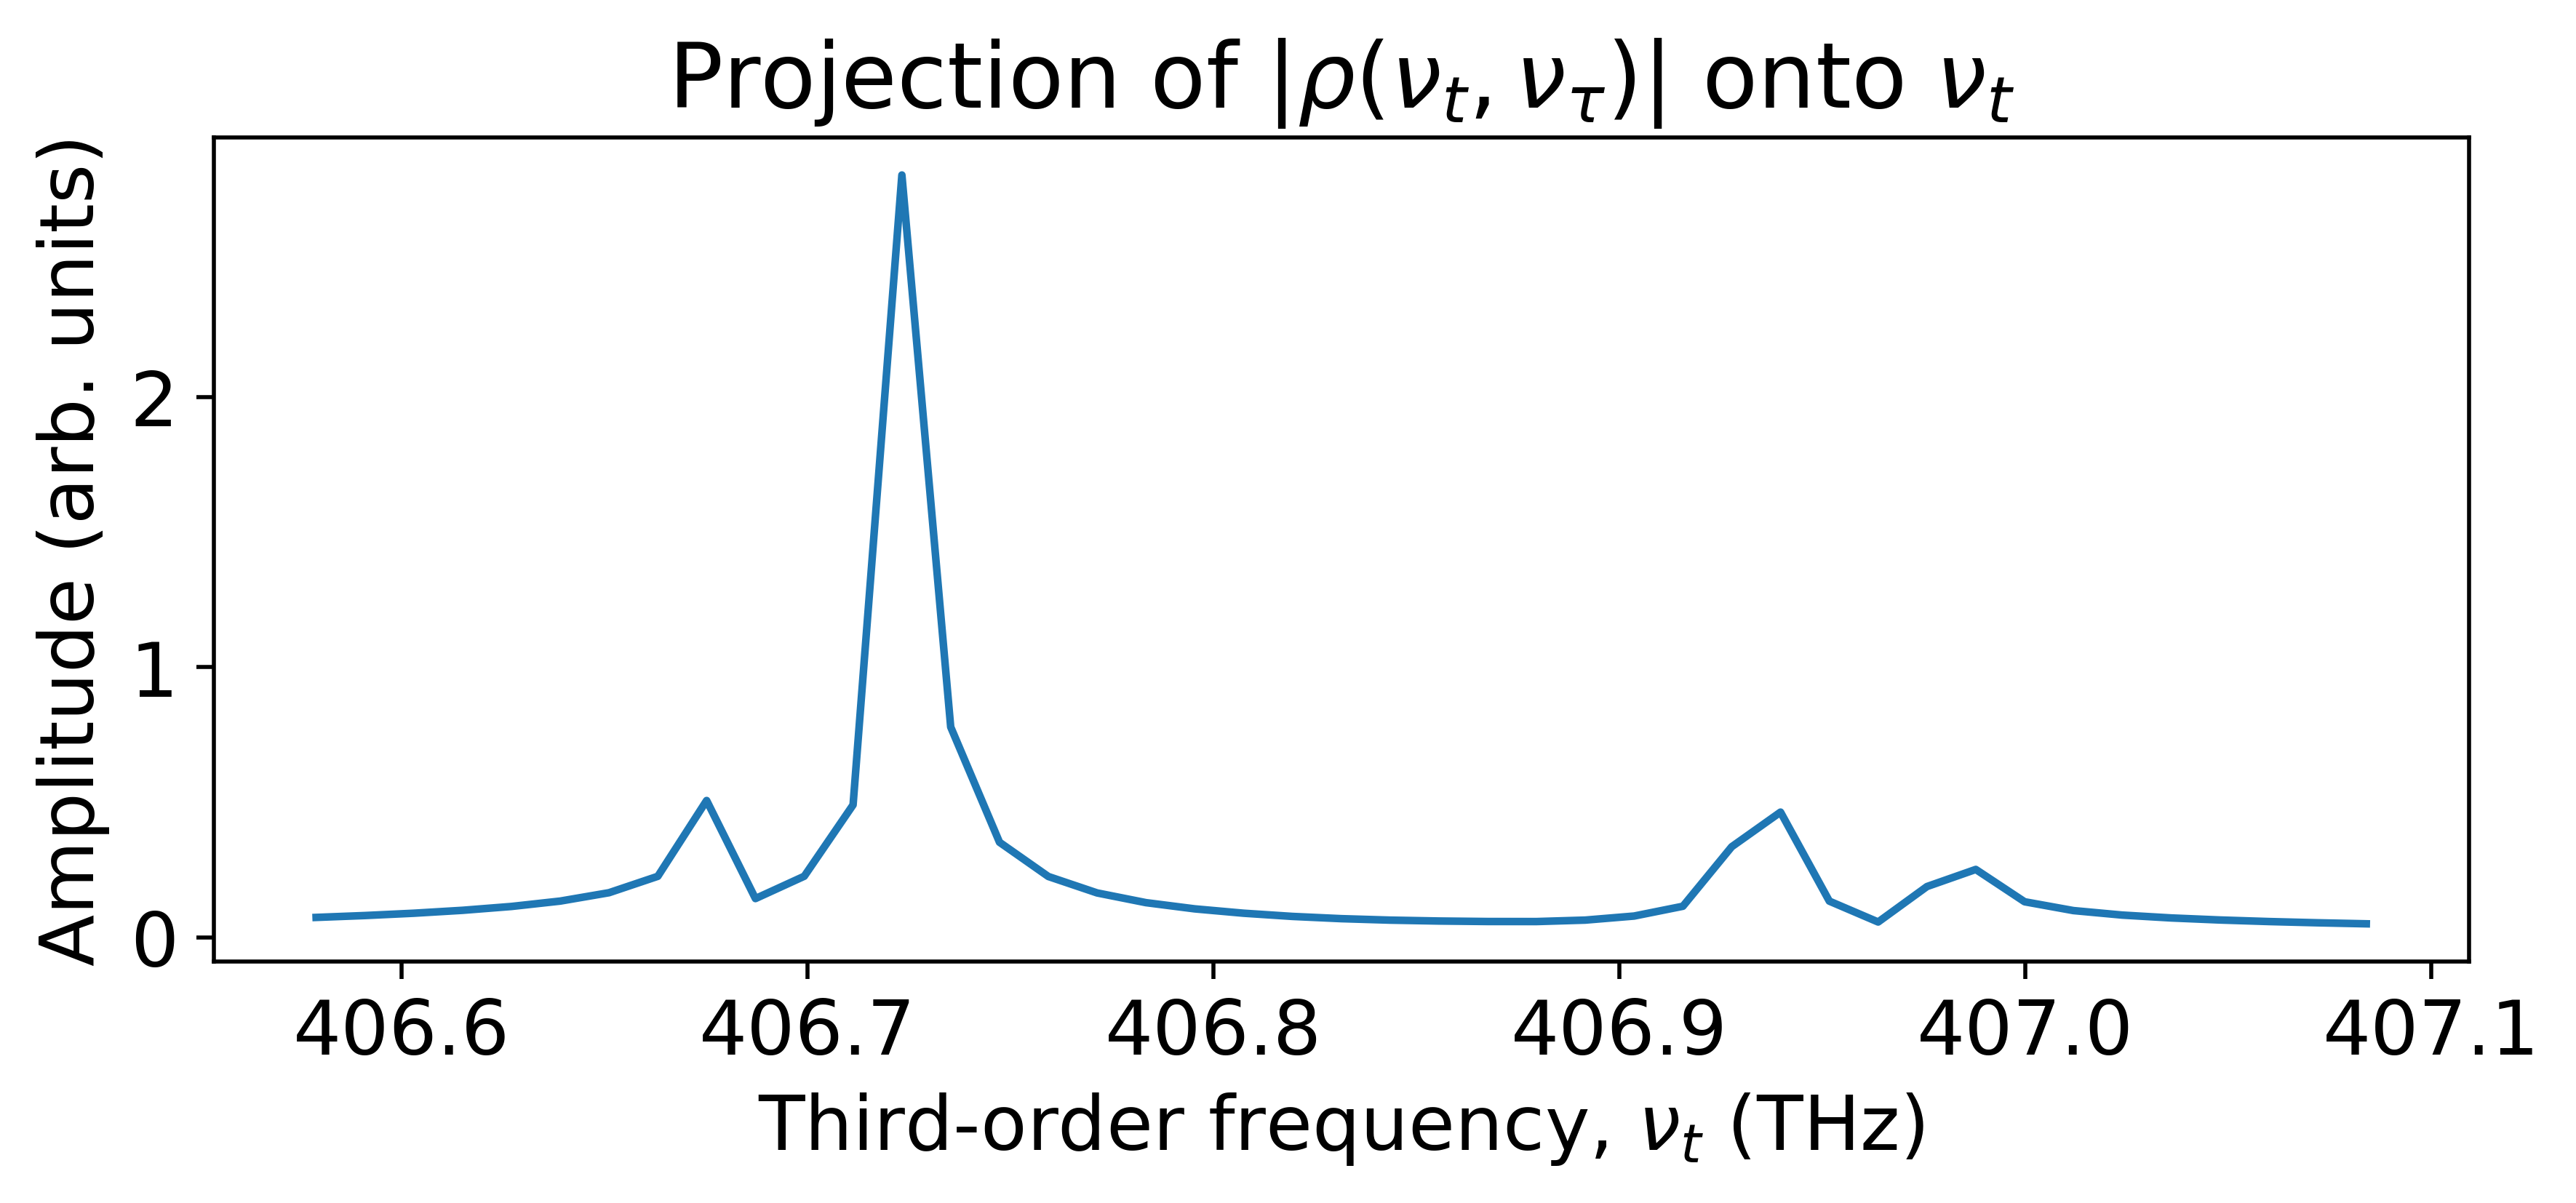

In [11]:
unstrained = np.sqrt(abs2(np.sum(RHO,
                                 axis=0)))  # unstrained
figrho = plt.figure(figsize=(8,3))
plt.plot(nu_t[minInd_t: maxInd_t+1], unstrained)
plt.title(
    r'Projection of $\left |\rho (\nu_t, \nu_\tau) \right |$ onto $\nu_t$')
plt.xlabel(r'Third-order frequency, $\nu_t$ (THz)')
plt.ylabel(r'Amplitude (arb. units)')
plt.show()

In [17]:
def projPlot(Z):

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    x = np.sum(Z, axis=0)
    y = np.sum(Z, axis=1)

    x /= max(x)
    y /= max(y)

    fig, ax = plt.subplots(figsize=(6, 6))
    EXTENT=(minPlt, maxPlt, -maxPlt, -minPlt)
    im = ax.imshow(Z, origin='lower', extent=EXTENT)

    # create new axes on the right and on the top of the current axes.
    divider = make_axes_locatable(ax)
    axtop = divider.append_axes("top", size="25%", pad=0.05, sharex=ax)
    axright = divider.append_axes("right", size="25%", pad=0.05, sharey=ax)

    label='arb. units'
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    if label is not None:
        plt.ylabel(label)

    #plot to the new axes
    axtop.plot(nu_t[minInd_t: maxInd_t+1], x)
    axright.plot(y, nu_tau[minInd_tau: maxInd_tau+1])
    axtop.get_xaxis().set_visible(False)
    axright.get_yaxis().set_visible(False)

    ax.set_ylabel(r'First-order frequency, $\nu_\tau$ (THz)')
    ax.set_xlabel(r'Third-order frequency, $\nu_t$ (THz)')
    axtop.set_title(r'$\left |\rho (\nu_t, \nu_\tau) \right |$')

    #adjust margins
    axright.margins(y=0)
    axtop.margins(x=0)
    plt.tight_layout()
    plt.show()
    return fig

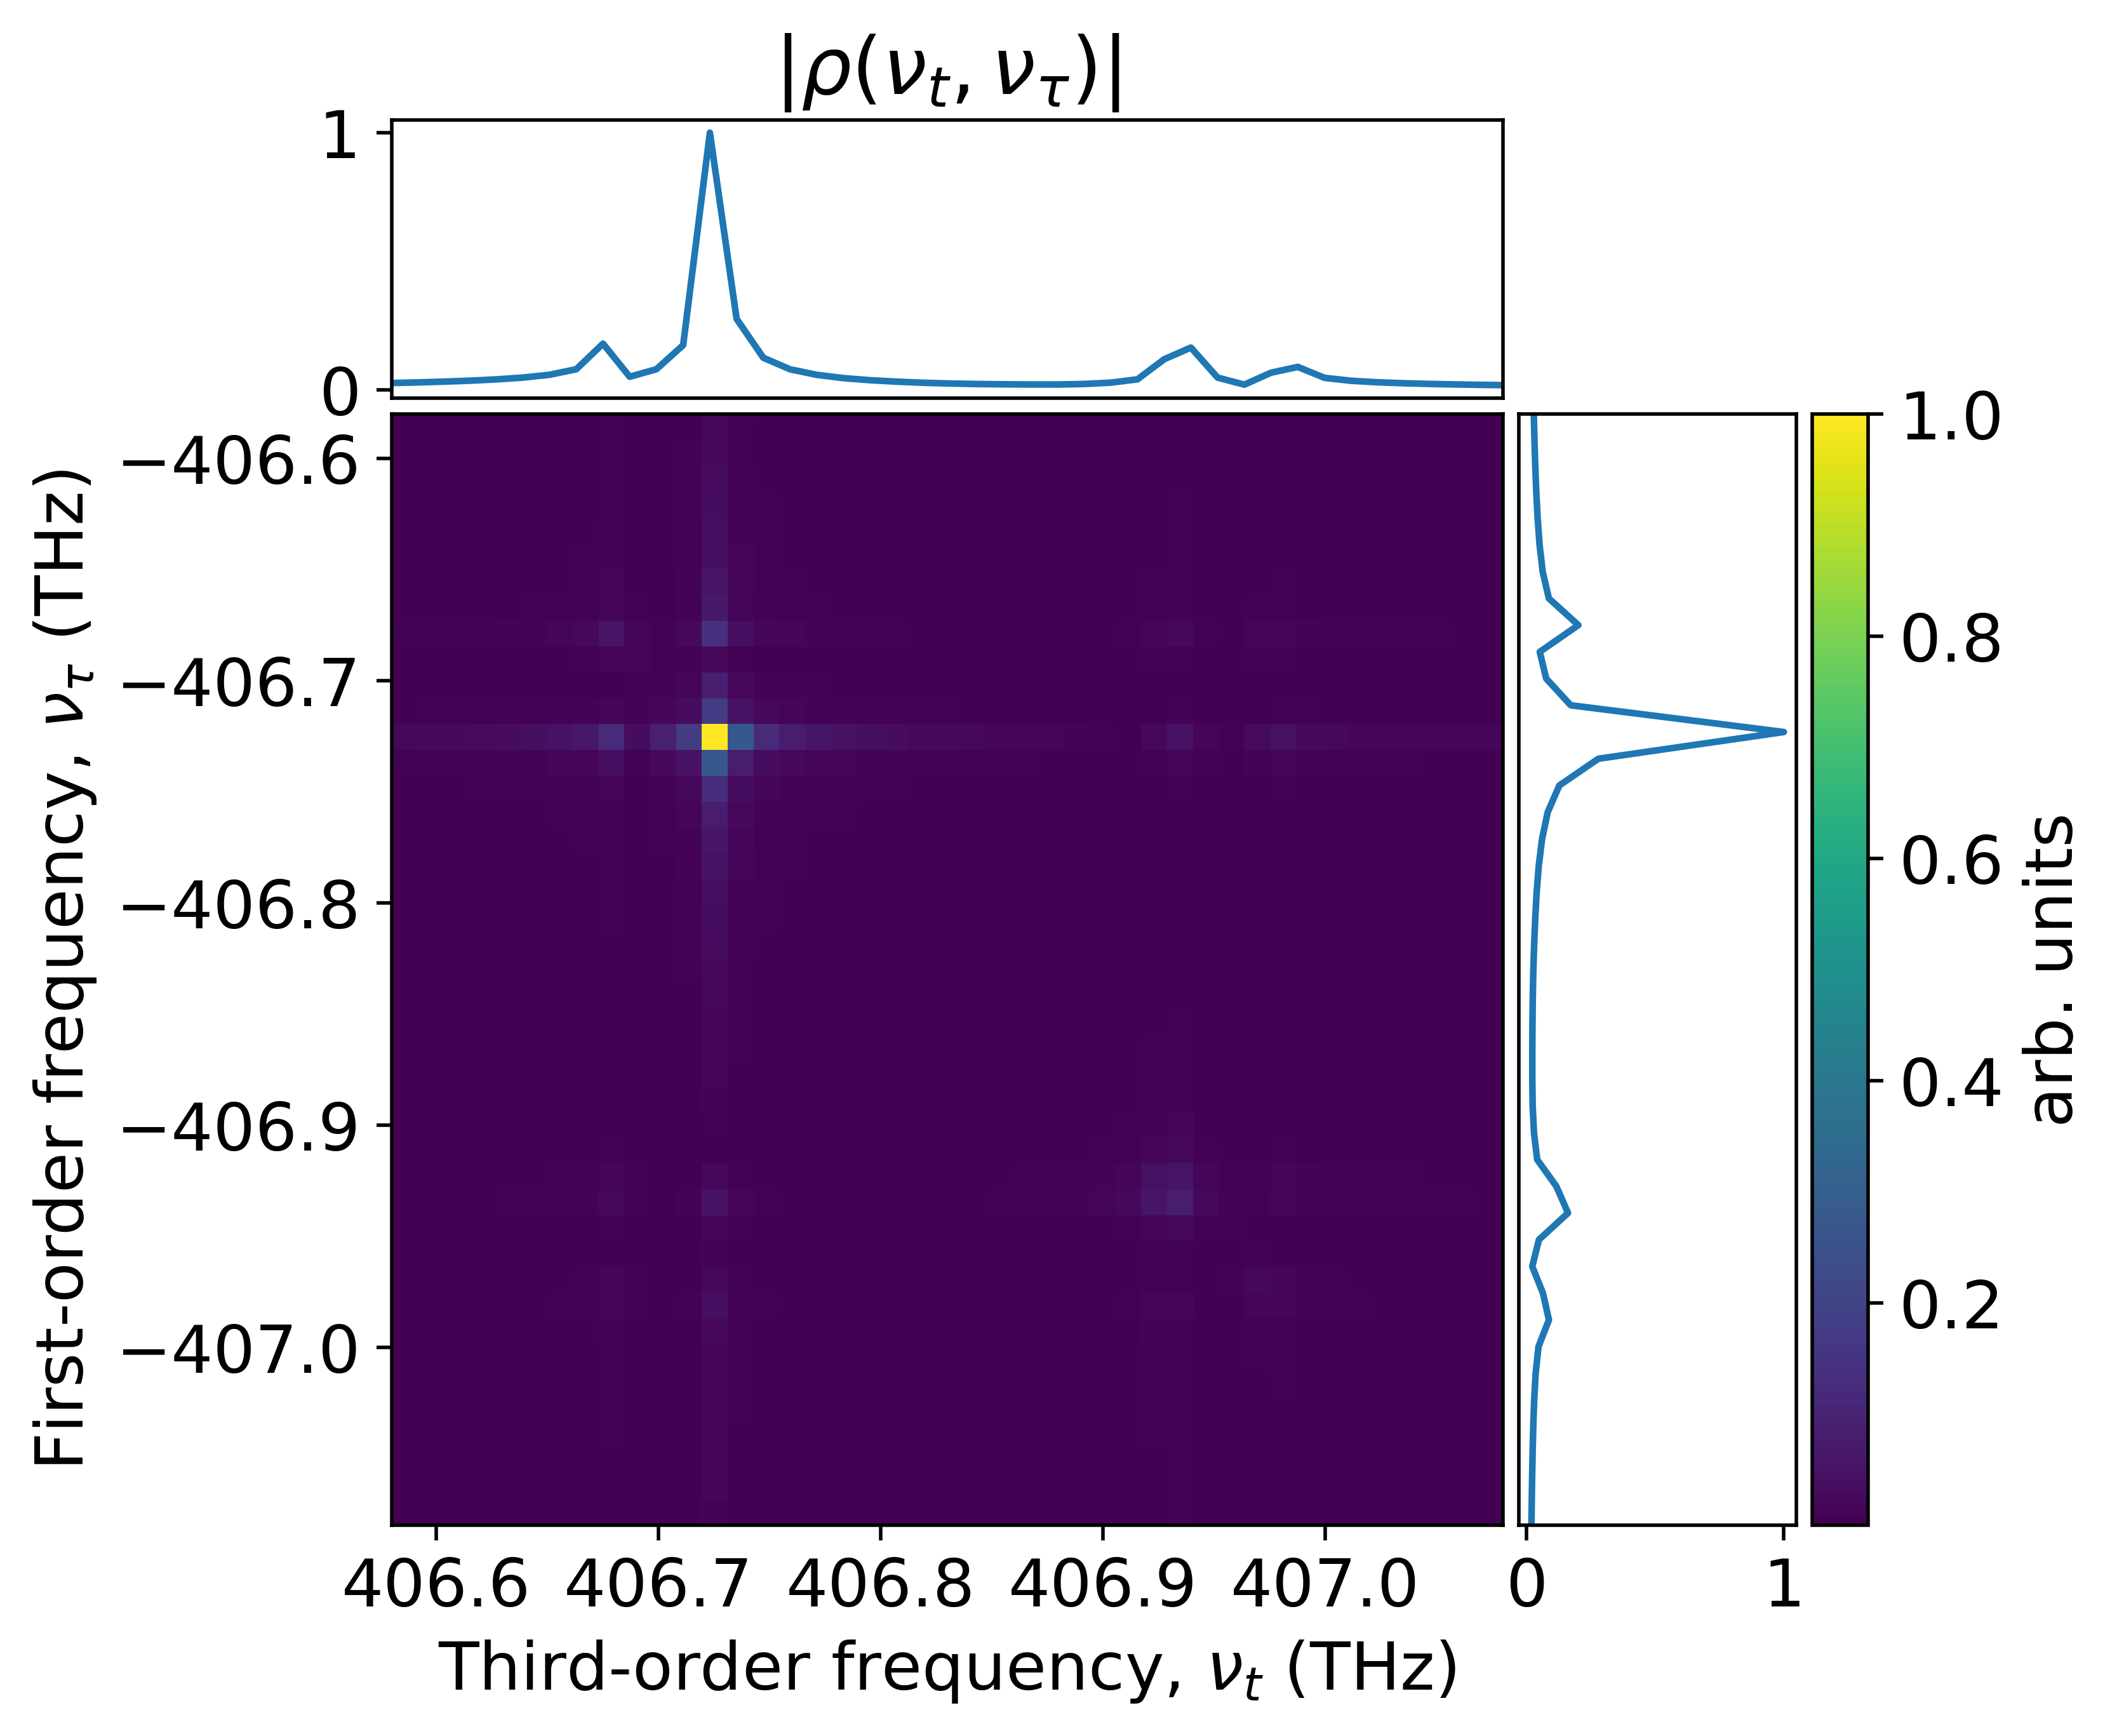

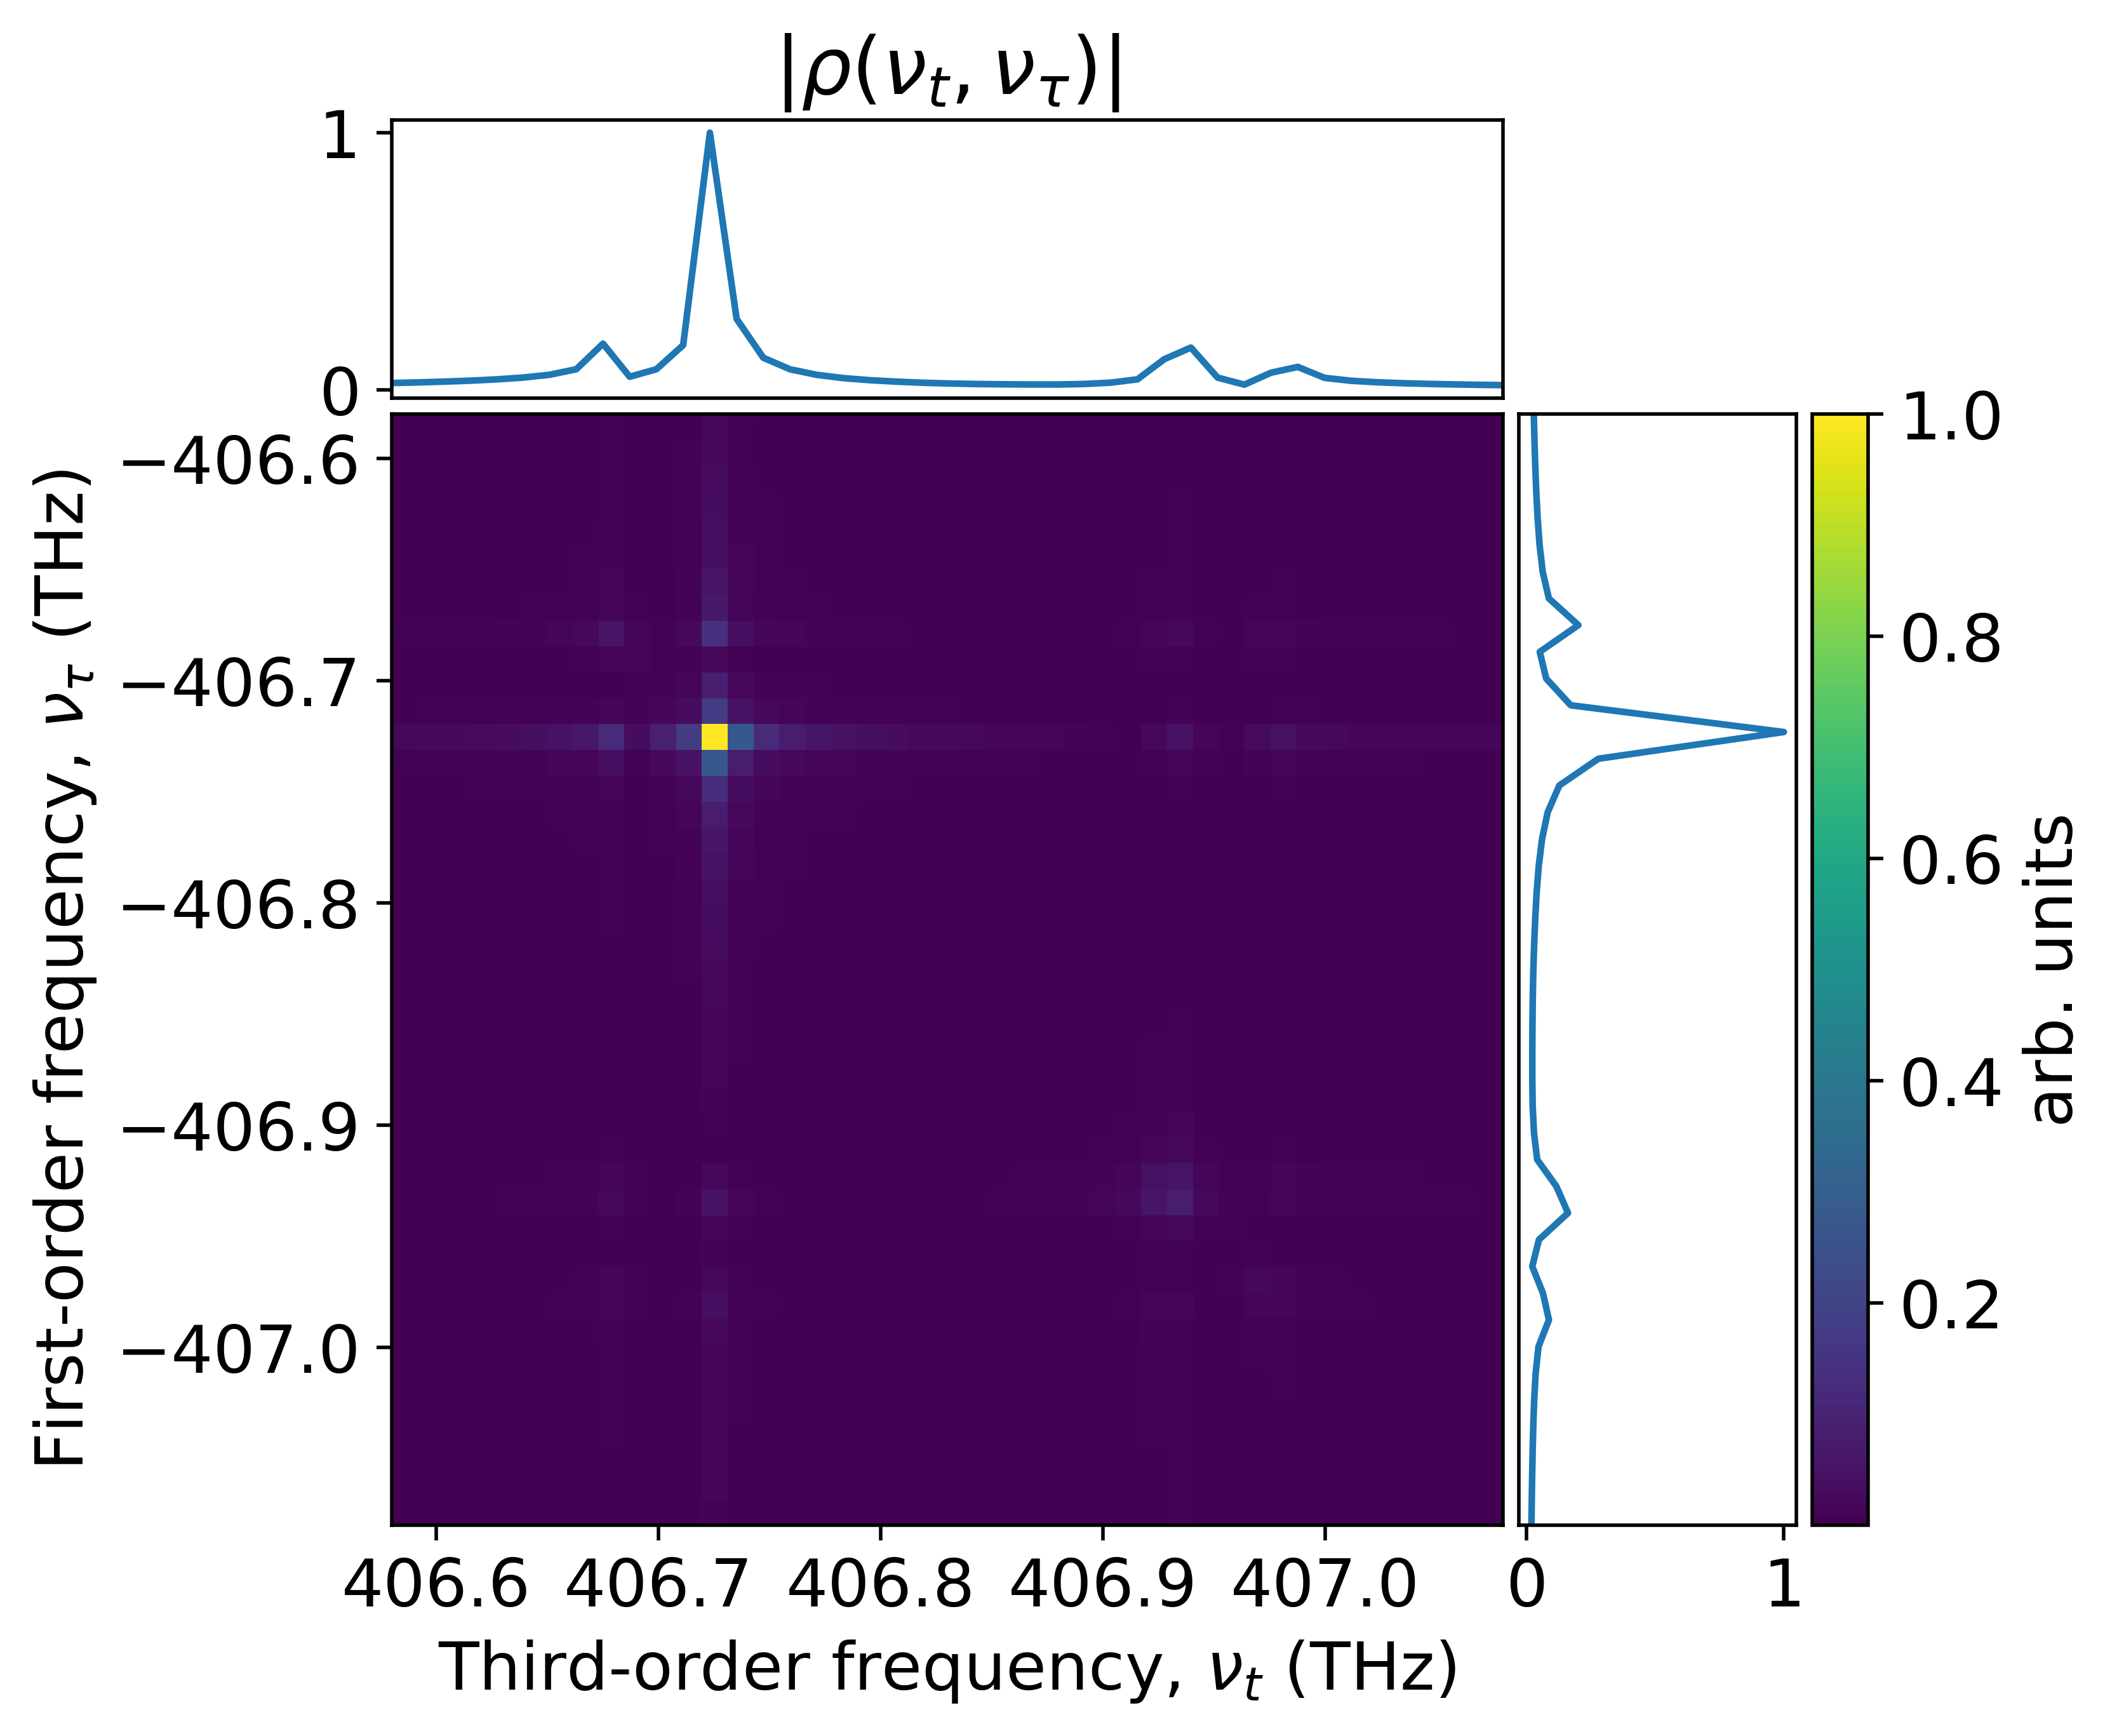

In [18]:
projPlot(RHO)

In [13]:
# @numba.jit
def mix_plots(
    databox,
    titles=None,
    figure_shape=[2, 1],
    figure_size=(3, 4.1),
    vertical_gap=0.,
    horizontal_gap=0.15,
    height_ratios=[1, 3],
    width_ratios=[1],
    shared_x_label=r'Third-order frequency, $\nu_t$ (THz)',
    shared_x_label_x_position=0.515,
    shared_x_label_y_position=0.09,
    shared_y_label=r'First-order frequency, $\nu_\tau$ (THz)',
    shared_y_label_x_position=0.08,
    shared_y_label_y_position=0.5,
    shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\nu_t, \nu_\tau) \right\}$',
    shared_title_x_position=0.515,
    shared_title_y_position=0.93,
    share_x_axis=True,
    share_y_axis=True,
    colorbar_labels='arb. units',
    EXTENT=(min(nu_t), max(nu_t), min(nu_tau), max(nu_tau))):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            'hspace': vertical_gap,
            'wspace': horizontal_gap,
            'height_ratios': height_ratios,
            'width_ratios': width_ratios
        })
    
    ax = ax.T

    for i in range(np.shape(databox)[0]):
        
        proj = np.sqrt(abs2(np.sum(databox[i], axis=0)))
        
        ax.flatten()[i].plot(proj)
#         ax.flatten()[i].set_title(titles[i])

        im = ax.flatten()[i+1].imshow(databox[i],
                                    origin='lower',
                                    extent=EXTENT)

#         if np.size(colorbar_labels) == 1:
#             if (i + 1) % figure_shape[1]:
#                 colorbar(im, None)
#             else:
#                 colorbar(im, colorbar_labels)
#         else:
#             colorbar(im, colorbar_labels[i])
            

#     fig.suptitle(x=shared_title_x_position,
#                  y=shared_title_y_position,
#                  t=shared_title,
#                  ha='center',
#                  size=1.5 * SIZE)

#     if shared_x_label != None:  # shared x label
#         fig.text(x=shared_x_label_x_position,
#                  y=shared_x_label_y_position,
#                  s=shared_x_label,
#                  ha='center')

#     if shared_y_label != None:  # shared y label
#         fig.text(x=shared_y_label_x_position,
#                  y=shared_y_label_y_position,
#                  s=shared_y_label,
#                  va='center',
#                  rotation='vertical')

    plt.show()
    return fig

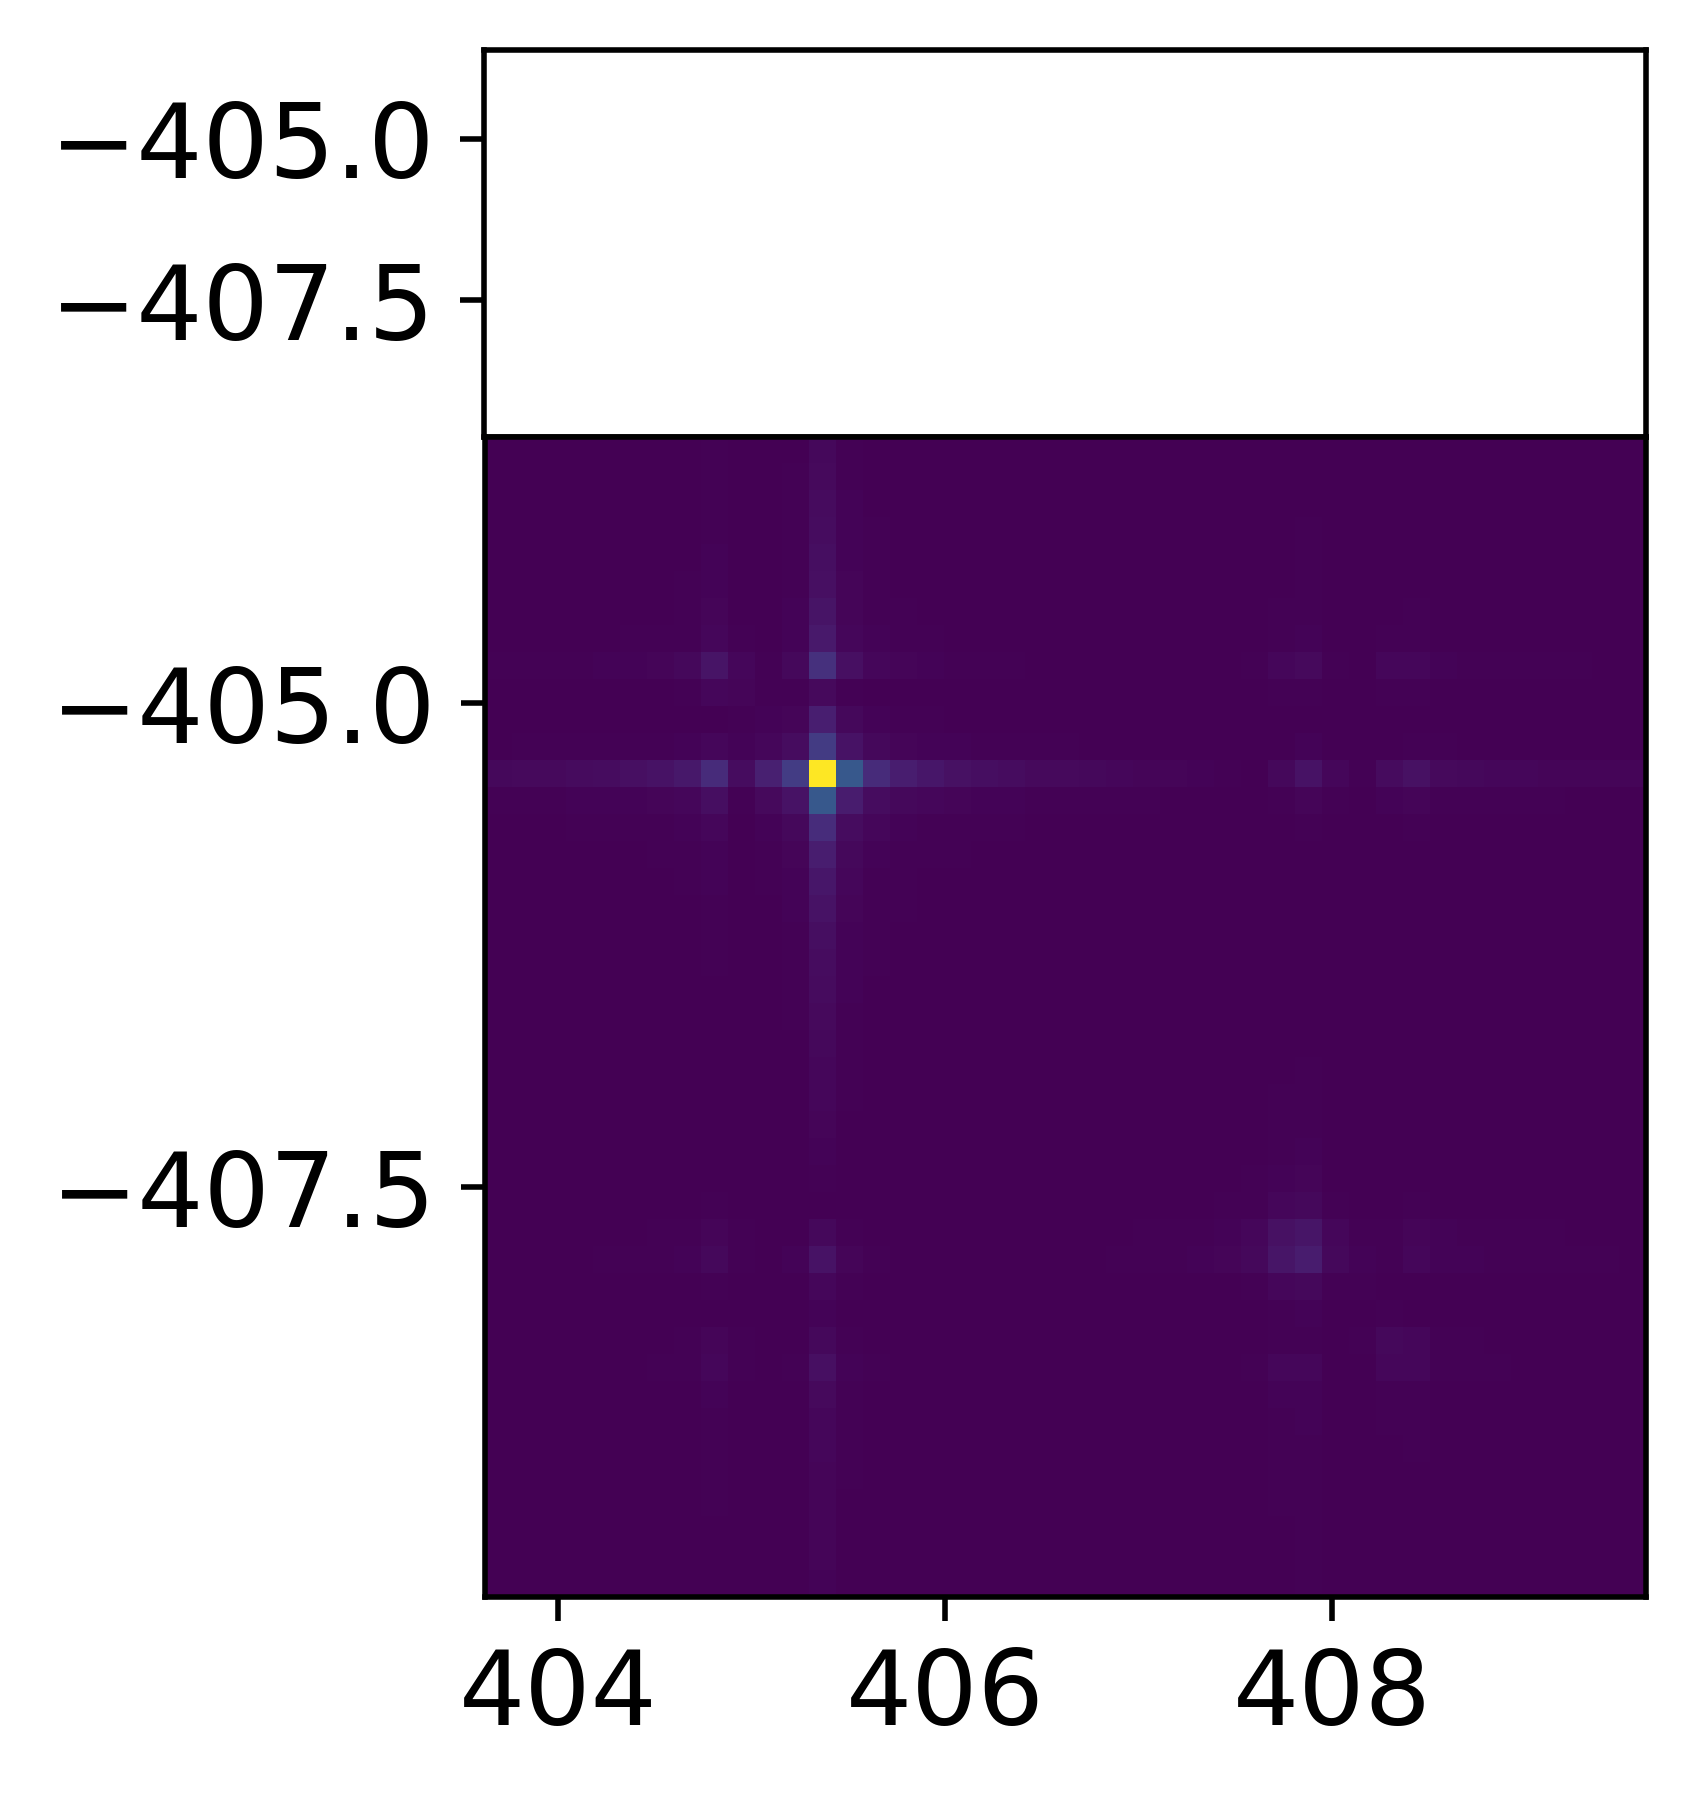

In [14]:
fig = mix_plots(np.array([RHO]))

figrho.savefig("/Users/tommychin/Documents/research/Smallwood_research/paper/LorentzProject.eps", 
                 format='eps', 
                 bbox_inches='tight')

StdDev = 0.2
StdDev2 = StdDev/4.

xx = np.linspace(-1., 2., 1000)
yy = np.exp(-xx**2./2./StdDev**2.)/StdDev/np.sqrt(2.*np.pi)
yy2 = np.exp(-(xx-1.)**2./2./StdDev2**2.)/StdDev2/np.sqrt(2.*np.pi)

yy_tot = yy+yy2

figGauss = plt.figure(figsize=(8,3))
plt.plot(xx, yy_tot/np.max(yy_tot))
plt.xlabel(r'$\epsilon_{ij}$ (Strain)')
plt.ylabel(r'Distribution')
plt.show()

figGauss.savefig("/Users/tommychin/Documents/research/Smallwood_research/MarchMeeting/Gauss2.pdf", 
                 format='pdf', 
                 bbox_inches='tight')